# Explore the data

The intention of this notebook is to explore the data and try out the methods of the developed library.

## Imports and basic definitions

In [1]:
import os

from rfa import *

NA = NetworkAnalyzer
import matplotlib.pyplot as plt

output_dir: str = "output/"
os.makedirs(output_dir, exist_ok=True)

reader = WikiDataReader("data/original.txt")

## Full Graph

In [2]:
graph_maker = WikiDataGraphMaker()
graph_maker.data = reader.data
g = graph_maker.make()

In [3]:

# basic statistics
print("number_of_nodes = ", NA.number_of_nodes(g))
print("number_of_edges = ", NA.number_of_edges(g))
print(
    "weakely_connected_components = ",
    NA.weakely_connected_components(g)["number_of_connected_componets"],
)
print("has cycle = ", NA.has_cycle(g))

number_of_nodes =  11256
number_of_edges =  184546
weakely_connected_components =  1
has cycle =  True


## Gephi

Export full graph to Gephi (it takes some time...)

In [4]:
gephi_file: str = os.path.join(output_dir, "gephi.gexf")
NA.export_to_gephi(g, gephi_file)
print(f"Gephi file '{gephi_file} written")

Gephi file 'output/gephi.gexf written


## Plot the number of votes per year

The number of votes is the 

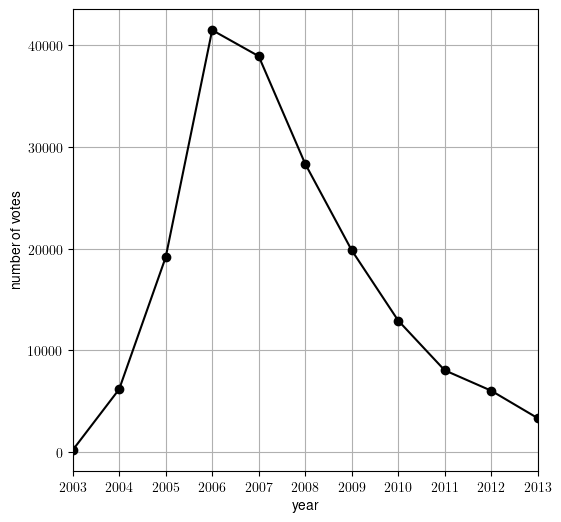

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot(
    ax,
    lambda g: g.number_of_edges(),
    y_label="number of votes",
)
fig.savefig(os.path.join(output_dir, "number_of_votes_per_year.png"))
plt.close(fig)
fig

## Quartiles

Plot the quartiles per year. We want to see how people's behavior changed over time.

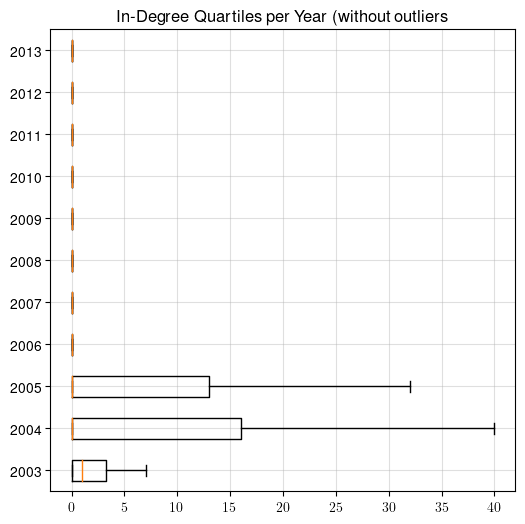

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax=ax,
    degree_type=DegreeType.IN,
    outliers=False,
)
fig.savefig(os.path.join(output_dir, "quartiles_out.png"))
plt.close(fig)
fig

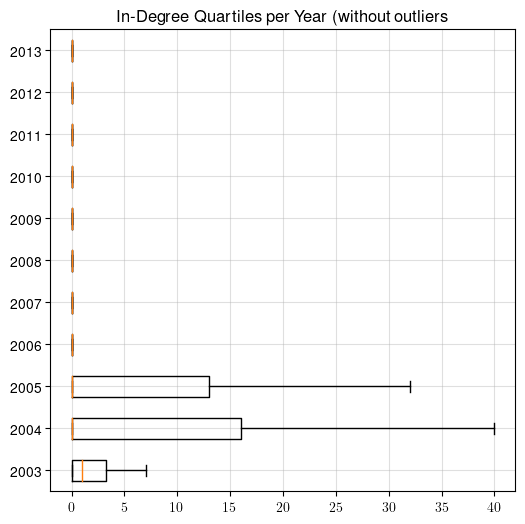

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax=ax,
    degree_type=DegreeType.IN,
    outliers=False,
)
fig.savefig(os.path.join(output_dir, "quartiles_in.png"))
plt.close(fig)
fig

## Cummulative Degree Distribution

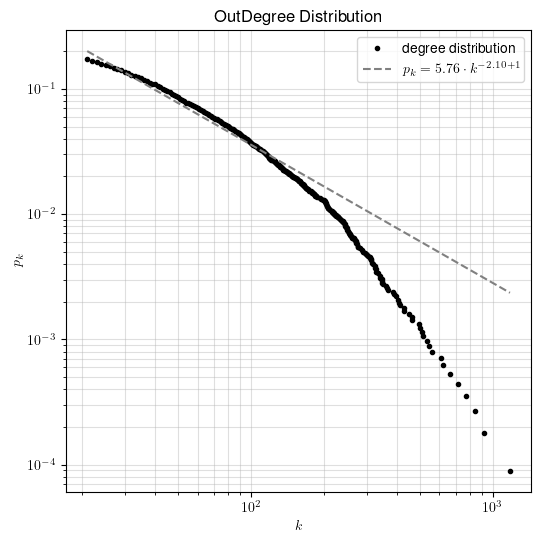

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cdd = CummulativeDegreeDistribution(g, DegreeType.OUT)
cdd.plot(ax)
fig.savefig(os.path.join(output_dir, cdd.file_name))
plt.close(fig)
fig

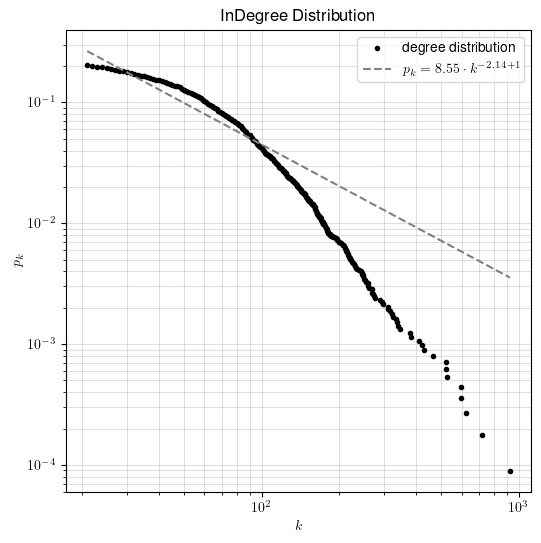

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cdd = CummulativeDegreeDistribution(g, DegreeType.IN)
cdd.plot(ax)
fig.savefig(os.path.join(output_dir, cdd.file_name))
plt.close(fig)
fig

## Simmetry between the in-degree and the out-degree

The in-degree and the out-degree seem to be equal. HOW COME?!?!?

Question: how many reverse arcs are present in the graph, i.e. given an arc `a = <i, j>`, the arc `a' = <j, i>` is present in which frequency?

In [10]:
import networkx as nx

def count_reverse_arc_fraction(dg: nx.MultiDiGraph) -> float:
    number_of_reverse_arcs_present: int = 0
    for arc in dg.edges():
        head, tail = arc
        if dg.has_edge(tail, head):
            number_of_reverse_arcs_present += 1
    return number_of_reverse_arcs_present / dg.number_of_edges()

count_reverse_arc_fraction(g)

0.07558549088032251

7.6% does not explain why in-degree is equals to out-degree... There must be something I am missing. Is the in-degree equals to the out-degree? What is the proportion?

In [11]:
import networkx as nx

def count_in_degree_equals_out_degree(dg: nx.MultiDiGraph) -> float:
    number_of_equal_degrees: int = 0
    for node in dg.nodes():
        if dg.in_degree(node) == dg.out_degree(node):
            number_of_equal_degrees += 1
    return number_of_equal_degrees / dg.number_of_nodes()

100 * count_in_degree_equals_out_degree(g)

0.13326226012793177

13% does not explain what I see. I will look for errors in my code! Indeed, it was the case...